In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn
import sklearn as sk

from tqdm import tqdm

from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import f1_score, make_scorer, roc_curve, auc

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Credit scoring
Analysis which allows to access a person's creditworthiness. Credit scoring is used to decide on whether to extend or deny credit. Such analysis helps the bank reduce financial risks.
### Goal
This is a binary classification problem: target variable has two states, 1 if client meet a default else 0. I'm interested to estimate the probability that a customer belongs to the first class (default variable in state 1). To solve the problem I need to choose suitable ML model and the best predictive combination of features.

# Data loading

In [3]:
data = pd.read_csv('train_kaggle.csv')
data['sample'] = np.zeros(len(data))  # flag train data with 0
test = pd.read_csv('test_kaggle.csv')
test['sample'] = np.ones(len(test))  # flag test data with 1

In [4]:
data_train = data.drop(['default'], axis=1)
target = data['default']
data = pd.concat([data_train, test])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 36348
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        110

### Description
* client_id - unique client id  
* education - level of education  
* sex - client gender  
* age - client's age
* car: 1 if client has a car else 0  
* car_type: 1 if client has a foreign car else 0  
* decline_app_cnt - number of previously rejected applications 
* good_work: 1 if client has a "good" job else 0  
* bki_request_cnt: number of bki requests  
* home_address: home address, categorical variable
* work_address: work address, categorical variable  
* income - client's income
* foreign_passport: 1 if client has foreign passport else 0 
* sna - client's relationship with other bank clients
* first_time - how long does the bank knows about client  
* score_bki - client's bki score based on data from bki  
* region_rating - region rating  
* app_date - date of application  
* default - 1 if client had a defaut else 0

# EDA & Data Preprocessing

In [6]:
# columns by types, some columns will be added soon
num_col = ['days_passed', 'age', 'decline_app_cnt', 'score_bki',
          'income']
cat_col = ['app_date_month', 'education', 'home_address', 'work_address', 'sna',
          'first_time', 'region_rating']
bin_col = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [7]:
# convert to datetime
data.app_date = pd.to_datetime(data.app_date)

## Education feature

proportion of nan: 0.004339615789664814
proportion of "ACD": 0.002641899989105567


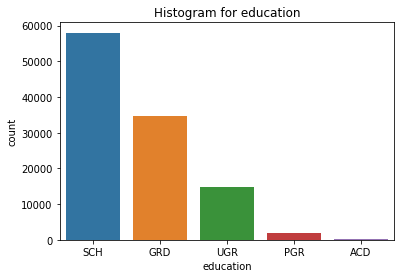

In [8]:
sns.countplot(data['education'])
plt.title('Histogram for education')
print('proportion of nan: {}'.format(data.education.isna().sum()/len(data)))
print('proportion of "ACD": {}'.format((data.education=='ACD').sum()/len(data)))

NA values can be filled in with the most popular category ('SCH' in this case). The proportion of nan is very small, but the proportion of 'ACD' category is even smaller. It is reasonable to define a separate class 'not defined'.

In [9]:
data.education.fillna('not defined', inplace=True)

## App_date feature
'Datetime' variable that has about 120 unique values. I tried to convert it into dummy variables, but that didn't improve the metric. So let's do some feature engeneering: col with number of days had passed by today (today is 27 July 2020) and categorical feature with the month of application submission.

In [10]:
# feature engeneering
day_27jul = pd.to_datetime('27JULY2020')

# number of days had passed by 27.07.2020, numerical var
data['days_passed'] = (day_27jul - data.app_date).dt.days

# month of application submission
data['app_date_month'] = data['app_date'].dt.month

## Distribution of numerical features

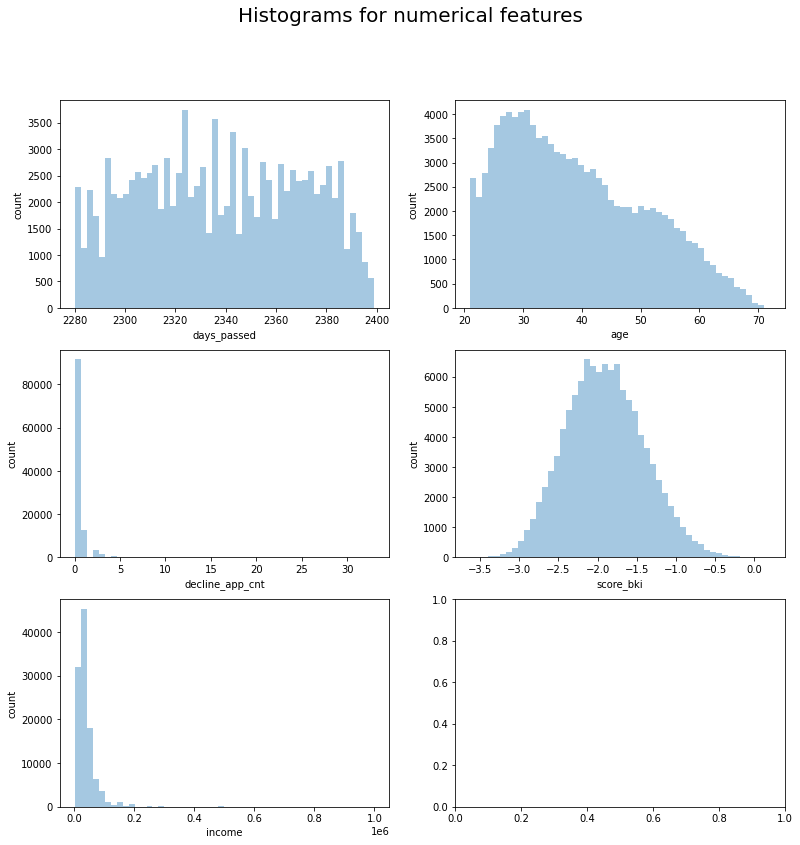

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(13,13))
for col, i in zip(num_col, range(6)):
    sns.distplot(data[col], kde=False, ax=axes.flat[i])
    axes.flat[i].set(ylabel='count')

fig.suptitle('Histograms for numerical features', fontsize=20);

## Outliers

In [12]:
def outliers_detection_IQR(data, col):
    
    # detect outliers in data[col]
    
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    IQR = perc75 - perc25
    left = perc25 - 1.5 * IQR
    right = perc75 + 1.5 * IQR
    print(col+' feature')
    print('min: {0}, max: {1}'.format(data[col].min(), data[col].max()))
    print('outlier boundaries: [{0}, {1}]'.format(left, right))
    if len(data[~data[col].between(left, right)]) > 0:
        print('ratio of outliers: {}'.format(len(data[(~data[col].between(left, right))&(~data[col].isna())])/len(data)))

def outliers_detect_prob(data, col):
    
    # built normal distribution
    mu = np.mean(data[col], axis=0)
    sigma = np.cov(data[col])
    distribution = norm(mu, sigma)
    
    # compute probability of being in the distribution
    # for each observation
    
    return distribution.pdf(data[col])

I filter data to consider only train samples and avoid data leakage while setting thresholds for outliers.

In [13]:
data_train = data.query('sample==0')  # to avoid data leakage
data_train[['decline_app_cnt', 'bki_request_cnt', 'income']].describe()

,decline_app_cnt,bki_request_cnt,income
count,73799.000000,73799.000000,73799.000000
mean,0.275749,2.000339,41099.775417
std,0.804272,2.252073,46166.322400
min,0.000000,0.000000,1000.000000
25%,0.000000,0.000000,20000.000000
50%,0.000000,1.000000,30000.000000
75%,0.000000,3.000000,48000.000000
max,33.000000,53.000000,1000000.000000


Outliers detection using **IQR method**:

In [14]:
outliers_detection_IQR(data_train, 'decline_app_cnt')

decline_app_cnt feature
min: 0, max: 33
outlier boundaries: [0.0, 0.0]
ratio of outliers: 0.17053076599953929


In [15]:
outliers_detection_IQR(data_train, 'bki_request_cnt')

bki_request_cnt feature
min: 0, max: 53
outlier boundaries: [-4.5, 7.5]
ratio of outliers: 0.023780810038076396


In [16]:
outliers_detection_IQR(data_train, 'income')

income feature
min: 1000, max: 1000000
outlier boundaries: [-22000.0, 90000.0]
ratio of outliers: 0.06361874822152061


I think it would be better to detect outliers simply by setting some thresholds. IQR method is too strict here in my opinion.

In [17]:
# setting thresholds

def detect_outliers_by_threshold(data, col, threshold, drop=False):
    
    ratio = (data[col]>=threshold).astype(int).sum()/len(data_train)
    print('{} feature\nthreshold: {}, proportion of outliers: {}'.format(
            col, threshold, ratio))
    
detect_outliers_by_threshold(data_train, 'decline_app_cnt', 5)
detect_outliers_by_threshold(data_train, 'bki_request_cnt', 10)
detect_outliers_by_threshold(data_train, 'income', 200000)

decline_app_cnt feature
threshold: 5, proportion of outliers: 0.005460778601336061
bki_request_cnt feature
threshold: 10, proportion of outliers: 0.01284570251629426
income feature
threshold: 200000, proportion of outliers: 0.014282036341955852


In [18]:
def drop_outliers_by_threshhold(data):
    
    # indicators if a value is bigger than threshold
    data['decline_app_cnt>=5'] = (data['decline_app_cnt']>=5).astype(int)
    data['bki_request_cnt>=10'] = (data['bki_request_cnt']>=10).astype(int)
    data['income>=100k'] = (data['income']>=200000).astype(int)
    
    # replacing outliers
    data['decline_app_cnt'] = data['decline_app_cnt'].apply(lambda x: -1 if x >= 5 else x)
    data['bki_request_cnt'] = data['bki_request_cnt'].apply(lambda x: -1 if x >= 10 else x)
    data['income'] = data['income'].apply(lambda x: -1 if x >= 200000 else x)
    
    return data

In [19]:
data = drop_outliers_by_threshhold(data)

## Default - target variable

In [20]:
def categorical_data(col, var_name):
    plt.figure(figsize=(7, 7))
    data_toplot = col.value_counts(normalize=True).sort_index()
    graph = sns.countplot(col, order=data_toplot.index)
    ax = graph.axes
    plt.title('Histogram for ' + var_name)
    for bar, value in zip(ax.patches, data_toplot):
        x_text = bar.get_x() + bar.get_width() / 2
        y_text = bar.get_height()
        ax.annotate('{}%'.format(round(100 * value, 2)), (x_text, y_text), ha='center', va='center',
                    fontsize=11, color='black', rotation=0, xytext=(0, 10), textcoords='offset points')
    plt.show()

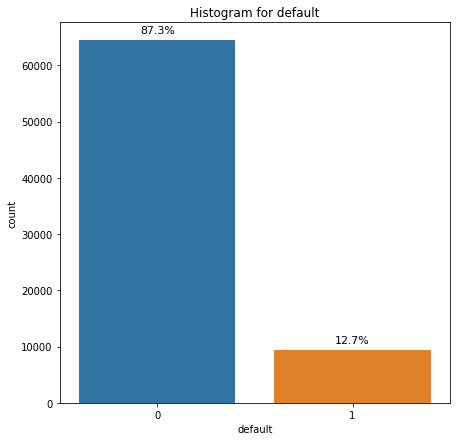

In [21]:
categorical_data(target, 'default')

Dataset is imbalanced, only about 13% of clients had met a default. This can lead to problems while identifying default clients in the future. I see two ways to solve this problem. Firstly, I will try to change class distribution with resampling methods (over-/undersampling or SMOTE algorithm). Secondly, after fitting a model I will analyse errors' distribution and try to improve "suitable" metrics.  
Article, which helped me with resampling techniques, can be found [here](https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/).

## Features' significance

### Visual assessment of categorical variables

In [22]:
def vis_importance(data, xcol, target):
    
    # plot histograms for categorical features to visualize
    # dependence on target variable
    # xcol - feature to explore
    
    dataset_to_plot = data.query('sample==0')  # use only train data
    dataset_to_plot['default'] = target
    crosstab = pd.crosstab(dataset_to_plot[xcol], dataset_to_plot['default'])
    
    graph = crosstab.plot(figsize=(12, 7), kind='bar')
    ax = graph.axes
    bars = []

    num_unique = dataset_to_plot[xcol].nunique()
    for i in range(num_unique):
        bars.append((ax.patches[i + num_unique], ax.patches[i]))
    
    for i, pair in enumerate(bars):
        x_text1 = pair[0].get_x() + pair[0].get_width() / 2
        y_text1 = pair[0].get_height()
    
        x_text0 = pair[1].get_x() + pair[1].get_width() / 2
        y_text0 = pair[1].get_height()
    
        prop_1 = crosstab.iloc[i].iloc[1] / (crosstab.iloc[i].iloc[0] + crosstab.iloc[i].iloc[1])
        prop_0 = crosstab.iloc[i].iloc[0] / (crosstab.iloc[i].iloc[0] + crosstab.iloc[i].iloc[1])
    
        ax.annotate('{}%'.format(round(100 * prop_1, 2)), (x_text1, y_text1), ha='center', va='center',
                    fontsize=11, color='black', rotation=0, xytext=(0, 10), textcoords='offset points')
        ax.annotate('{}%'.format(round(100 * prop_0, 2)), (x_text0, y_text0), ha='center', va='center',
                    fontsize=11, color='black', rotation=0, xytext=(0, 10), textcoords='offset points')

    plt.title('Histogram for '+xcol)
    plt.xlabel(xcol)
    plt.ylabel('Frequency of default')
    plt.show()

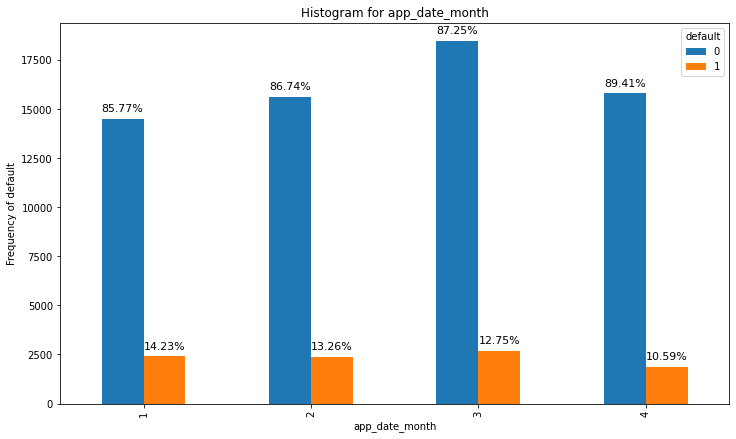

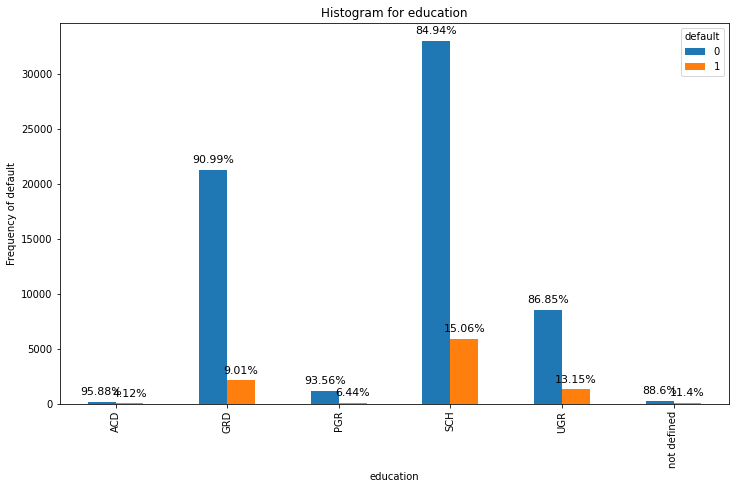

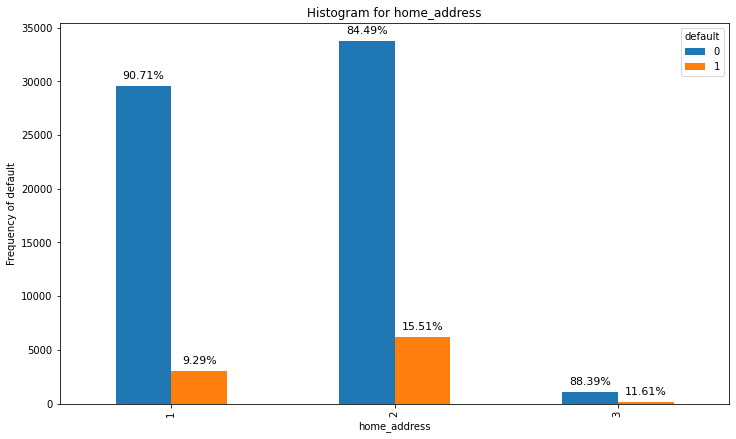

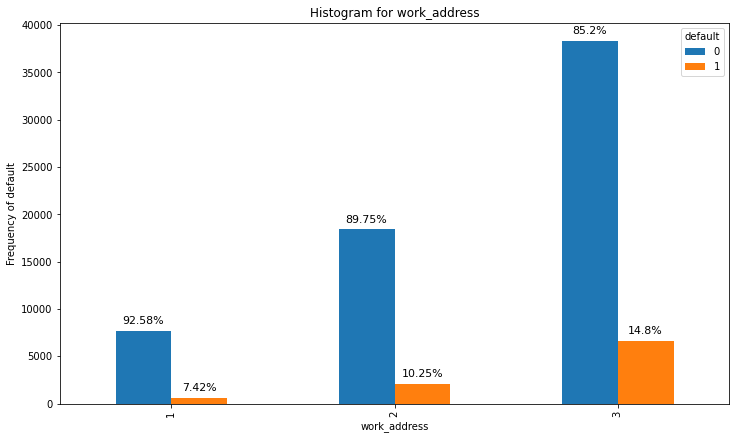

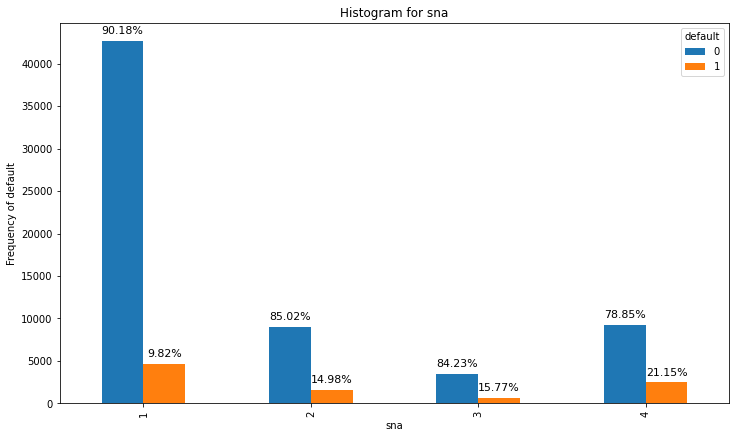

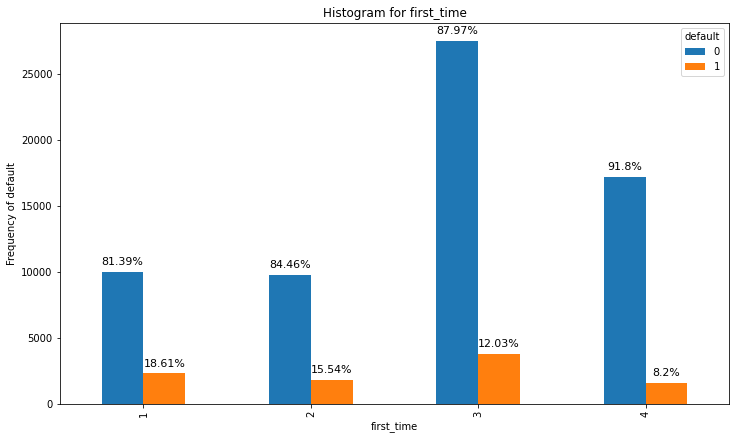

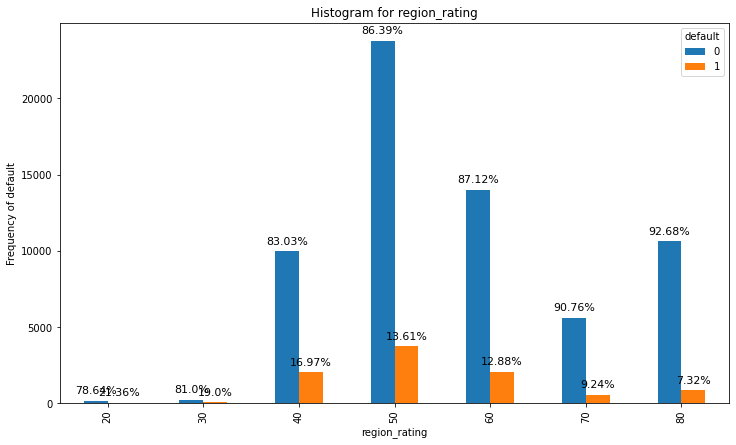

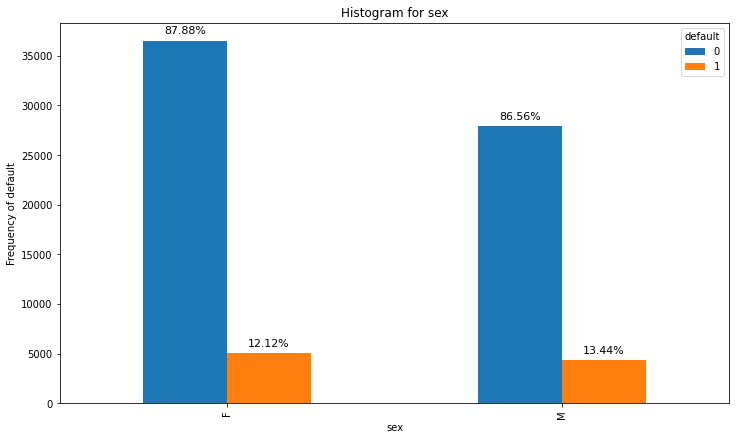

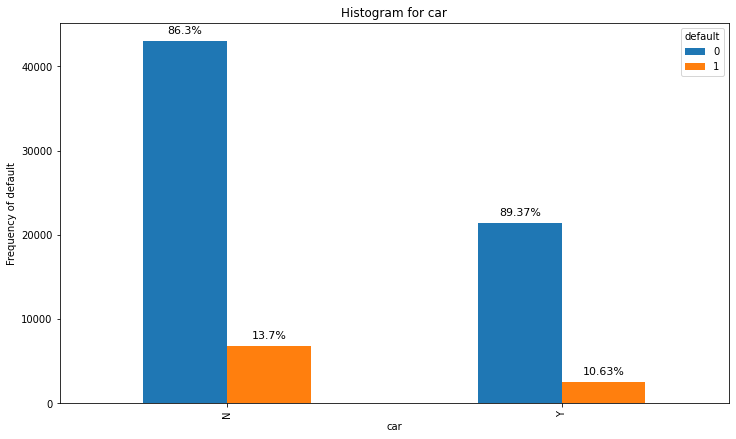

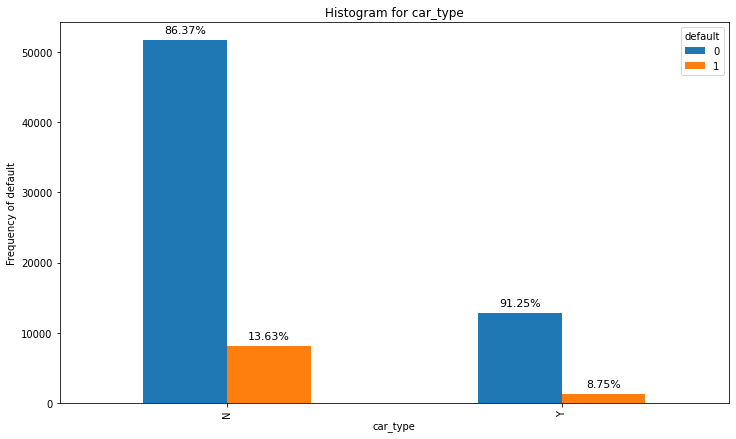

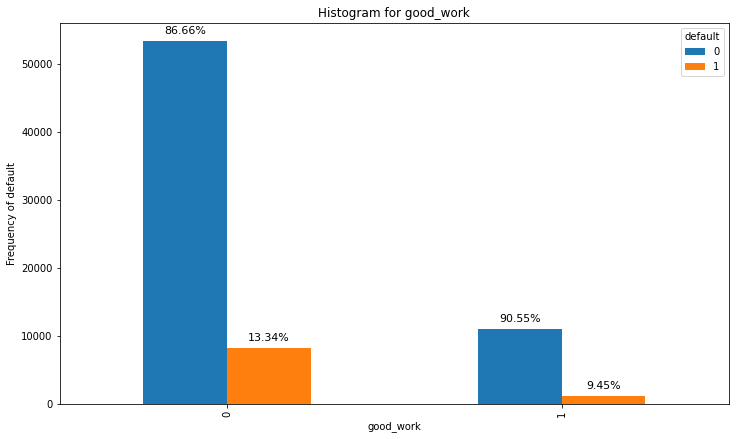

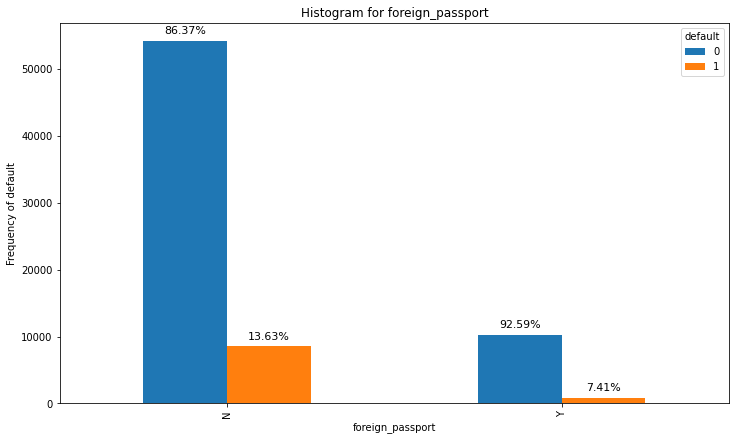

In [23]:
for col in cat_col + bin_col:
    vis_importance(data, col, target)

To make more accurate observations I wrote proportions of default ("1") and not default ("0") clients in each group for every feature. For example, in **'first_time'** feature in group 2 there are 11568 people in total, 9770 are "0" and 1798 are "1", so 84.46% of "0" and 15.54% of "1".  
In **'app_date_month'** & **'sex'** features the ratio of defaults in different categories is almost the same. Groups in **'home_address'**, **'education'**, **'work_address'**, **'first_time'**, **'car'**, **'car_type'**, **'good_work'** & **'foreign_passport'** features have no more than 10% difference in proportions of "0"s. The strongest dissimilarity can be seen in **'sna'** & **'region_rating'** features. ('sna': ~10% of "0"s in group 1 and ~21% of "0"s in group 4, 'region_rating' ~7% of "0"s in group 80 compared with ~21% in group 20).

### Visual assessment of numerical variables

In [24]:
def get_boxplot(data, column):
    
    # plot boxplots for numerical features
    
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x='default', y=column,
                data=data,
                ax=ax, showmeans=True)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

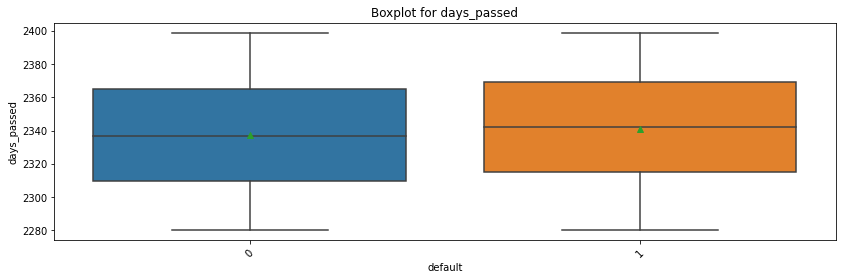

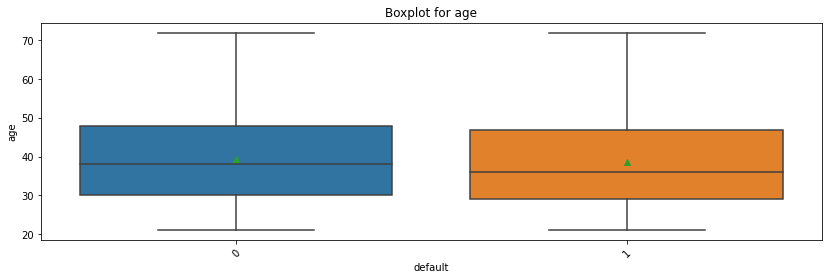

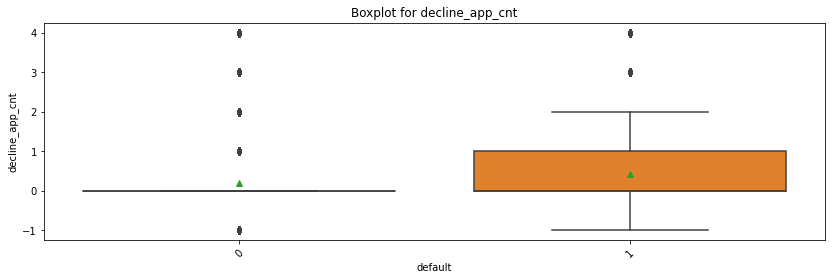

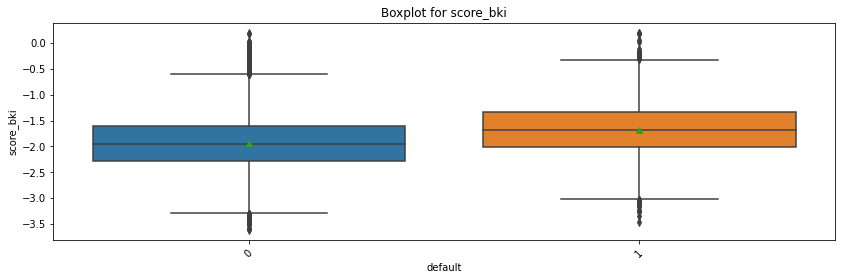

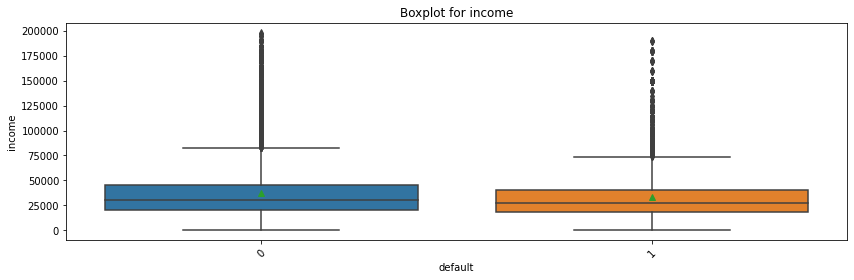

In [25]:
dataset_to_plot = data.query('sample==0')
dataset_to_plot['default'] = target
for col in num_col:
    get_boxplot(dataset_to_plot, col)

Notice that default clients have higher median and mean values in **'days_passed'** & **'score_bki'** features than non-default ones. It works the other way around in **'age'** & **'region_rating'** features. Another observation is that default clients have signifiantly different value ranges in **'decline_app_cnt'** & **'score_bki'** features.

### Statistical assessment of categorical variables

In [26]:
# encoding categorical cols
for col in ['education', 'sex', 'car', 'car_type', 'foreign_passport']:
    encoded_vals, _ = pd.factorize(data[col])
    data[col] = encoded_vals
    
for col in ['education', 'sex', 'car', 'car_type', 'foreign_passport']:
    encoded_vals, _ = pd.factorize(test[col])
    test[col] = encoded_vals

<AxesSubplot:>

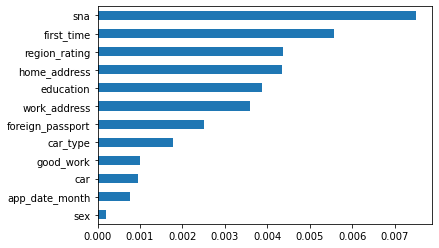

In [27]:
# check importance of categorical variables
imp_cat = pd.Series(mutual_info_classif(data.query('sample==0')[bin_col + cat_col],
                                        target, discrete_features =True),
                    index = bin_col + cat_col)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

### Statistical assessment of numerical variables

Text(0.5, 0, 'F-value')

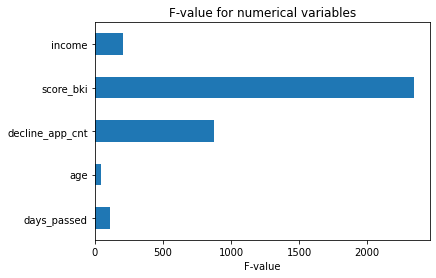

In [28]:
# check importance of numerical variables
imp_num = pd.Series(f_classif(data.query('sample==0')[num_col],
                              target)[0], index=num_col)
imp_num.plot(kind='barh')
plt.title('F-value for numerical variables')
plt.xlabel('F-value')

## Correlation matrix

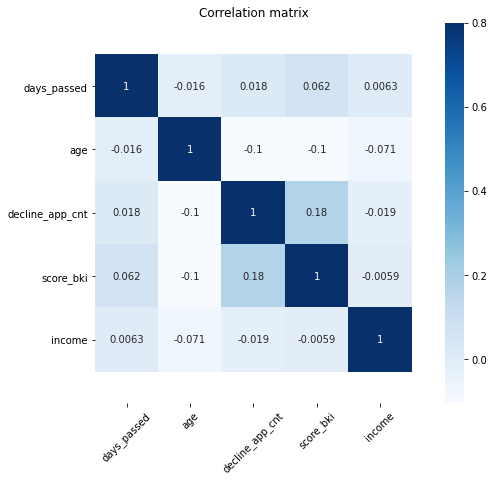

In [29]:
corrmat = data[num_col].corr()
f, ax = plt.subplots(figsize=(12, 7))
chart = sns.heatmap(corrmat, vmax=.8, square=True, annot=True, cmap='Blues')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.set_yticklabels(chart.get_yticklabels(), rotation=360)
bottom, top = chart.get_ylim()
plt.title('Correlation matrix')
ax.set_ylim(bottom + 0.5, top - 0.5);

There is no strong correlation between any features. That's cool, let's go further.

# Data Preprocessing

In [30]:
def prepare_data(data, target, num_col, cat_col, bin_col):
    # categorical variables -> dummy-variables
    X_cat_train = sk.preprocessing.OneHotEncoder(sparse=
                        False).fit_transform(data.query('sample==0')[cat_col].values)
    X_cat_test = sk.preprocessing.OneHotEncoder(sparse=
                        False).fit_transform(data.query('sample==1')[cat_col].values)
    # polynomial feature engeneering
    X_num_train = PolynomialFeatures(2).fit_transform(data.query('sample==0')[num_col].values)
    X_num_test = PolynomialFeatures(2).fit_transform(data.query('sample==1')[num_col].values)
    
    scaler = sk.preprocessing.StandardScaler().fit(X_num_train)  # fit only on train data to avoid data leakage
    X_num_train = scaler.transform(X_num_train)
    X_num_test = scaler.transform(X_num_test)
    
    X_train = np.hstack([X_cat_train, X_num_train, data.query('sample==0')[bin_col].values])
    X_test = np.hstack([X_cat_test, X_num_test, data.query('sample==1')[bin_col].values])
    y_train = target.values
    
    return X_train, y_train, X_test

In [31]:
X_train, y_train, X_test = prepare_data(data, target, num_col, cat_col, bin_col)

I have train (X_train, y_train) and test data (only X_test) from Kaggle competition (find it [here](https://www.kaggle.com/c/sf-dst-scoring)). I should train model on train data, predict target variable based on test data and submit my prediction. But I want to evaluate the quality of the model before submission, so I will split train dataset one more time on smaller train dataset (named it "pretrain") and validation dataset.

In [32]:
X_pretrain, X_valid, y_pretrain, y_valid = sk.model_selection.train_test_split(X_train, y_train, test_size=0.3, random_state=33)

# Model fitting

There I fit the Logistic Regression model that would be my starting point.

In [33]:
def predict_baseline(X_tr, X_te, y_tr, y_te):
    logreg = sk.linear_model.LogisticRegression(random_state=33, max_iter=500)
    model = logreg.fit(X_tr, y_tr)

    y_pre_probs = model.predict_proba(X_te)[:, 1]
    y_pre = model.predict(X_te)
    print(model.get_params)
    
    return model, y_pre_probs, y_pre

In [34]:
def predict_weightened_logreg(X_tr, X_te, y_tr, y_te):
    logreg = sk.linear_model.LogisticRegression(class_weight='balanced', random_state=33,
                                                solver='lbfgs', max_iter=500)
    model = logreg.fit(X_tr, y_tr)

    y_pre_probs = model.predict_proba(X_te)[:, 1]
    y_pre = model.predict(X_te)
    print(model.get_params)
    
    return model, y_pre_probs, y_pre

# Validation

In [35]:
def roc_auc_curve(y_true, y_predict_probs):
    fpr, tpr, threshold = sk.metrics.roc_curve(y_valid, y_predict_probs)
    roc_auc = sk.metrics.roc_auc_score(y_valid, y_predict_probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression validation ROC AUC = {}'.format(roc_auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [36]:
model_baseline, y_pre_probs_baseline, y_pre_baseline = predict_baseline(X_pretrain, X_valid, y_pretrain, y_valid)
model_weightened_logreg, y_pre_probs_weightened, y_pre_weightened = predict_weightened_logreg(X_pretrain, X_valid, y_pretrain, y_valid)

<bound method BaseEstimator.get_params of LogisticRegression(max_iter=500, random_state=33)>
<bound method BaseEstimator.get_params of LogisticRegression(class_weight='balanced', max_iter=500, random_state=33)>


LogReg with default parameters


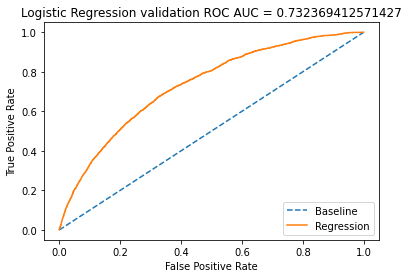

F1 score:  0.04442925495557074
 
Weightened LogReg


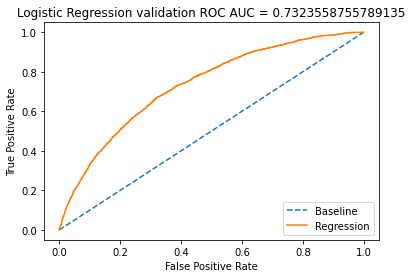

F1 score:  0.33913511573658706


In [37]:
print('LogReg with default parameters')
roc_auc_curve(y_valid, y_pre_probs_baseline)
print('F1 score: ', f1_score(y_valid, y_pre_baseline))

print(' \nWeightened LogReg')
roc_auc_curve(y_valid, y_pre_probs_weightened)
print('F1 score: ', f1_score(y_valid, y_pre_weightened))

I monitor **F1 score**, which is sensitive to model's ability to separate classes (it will help to see model's mistakes out of imbalance in data). In this case it higlights that model performs much better if classes' imbalance is taken into account (through class_weight parameter).

Text(0.5, 1.0, 'Classes are weightened')

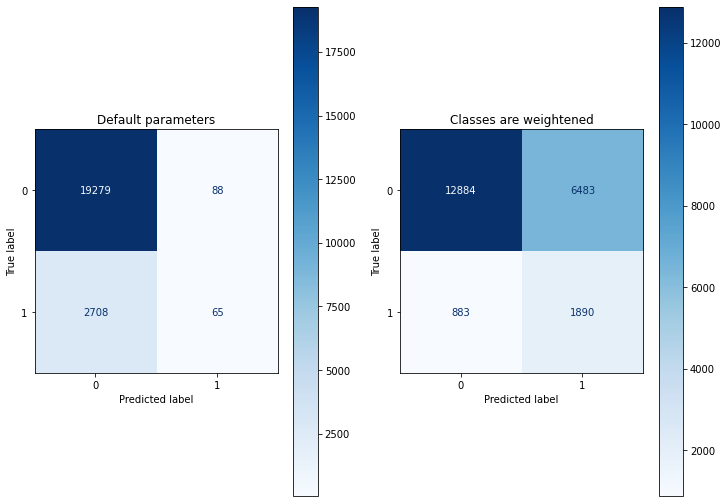

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,9))
sk.metrics.plot_confusion_matrix(model_baseline, X_valid, y_valid, ax=axes[0], cmap='Blues')
axes[0].set_title('Default parameters')
sk.metrics.plot_confusion_matrix(model_weightened_logreg, X_valid, y_valid, ax=axes[1], cmap='Blues')
axes[1].set_title('Classes are weightened')

Considering data imbalance via weightes does not improve ROC AUC metric, but it improves F1 score. Confusion matrix prove that the second model is much better in identifying default class. The bad news is that the second model made in total more mistakes than the first one (1st: 2708+88=2796 mistakes, 2nd: 883+6486=7369 mistackes). But even so the second model make less II type errors (883 < 2708) (It means that we provide credit for clients, who will meet a default, less frequently).  
A lot of errors are due to data imbalance.  
What I'm also going to try to improve model's performance:  
\- resampling methods to reduce imbalance  
\- examining samples where model made mistakes  
\- searching for the best hyperparametrs with the help of sklearn GridSearchCV method

## Resampling

In [39]:
def resampling_strategy1(X_tr, y_tr):
    # combine over- and undersampling
    
    over = imblearn.over_sampling.RandomOverSampler(sampling_strategy=0.4)
    under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.8)
    
    X_resamp, y_resamp = over.fit_resample(X_tr.copy(), y_tr.copy())
    X_resamp, y_resamp = under.fit_resample(X_resamp, y_resamp)
    
    return X_resamp, y_resamp

In [40]:
def resampling_strategy2(X_tr, y_tr):
    # combine SMOTE and undersampling
    
    smote = imblearn.over_sampling.SMOTE(sampling_strategy=0.7)
    under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.8)
    
    X_resamp, y_resamp = smote.fit_resample(X_tr.copy(), y_tr.copy())
    X_resamp, y_resamp = under.fit_resample(X_resamp, y_resamp)
    
    return X_resamp, y_resamp

Text(0.5, 1.0, 'Combining SMOTE and random undersampling')

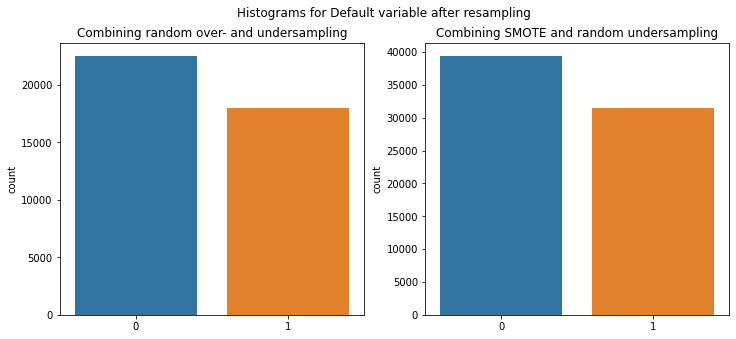

In [41]:
X_pretrain_resamp1, y_pretrain_resamp1 = resampling_strategy1(X_pretrain, y_pretrain)

# reset settings on data
X_train, y_train, X_test = prepare_data(data, target, num_col, cat_col, bin_col)
X_pretrain, X_valid, y_pretrain, y_valid = sk.model_selection.train_test_split(X_train, y_train, test_size=0.3, random_state=33)

X_pretrain_resamp2, y_pretrain_resamp2 = resampling_strategy2(X_pretrain, y_pretrain)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plt.suptitle('Histograms for Default variable after resampling')
sns.countplot(y_pretrain_resamp1, ax=axes[0])
axes[0].set_title('Combining random over- and undersampling')

sns.countplot(y_pretrain_resamp2, ax=axes[1])
axes[1].set_title('Combining SMOTE and random undersampling')

<bound method BaseEstimator.get_params of LogisticRegression(max_iter=500, random_state=33)>


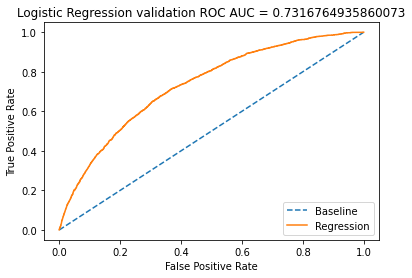

F1 score:  0.34596800171802855


In [42]:
model_resamp1, y_pre_probs_resamp1, y_pre_resamp1 = predict_baseline(X_pretrain_resamp1, X_valid, y_pretrain_resamp1, y_valid)
roc_auc_curve(y_valid, y_pre_probs_resamp1)
print('F1 score: ', f1_score(y_valid, y_pre_resamp1))

F1-score becomes slightly better with the 1st resampling strategy!

<bound method BaseEstimator.get_params of LogisticRegression(max_iter=500, random_state=33)>


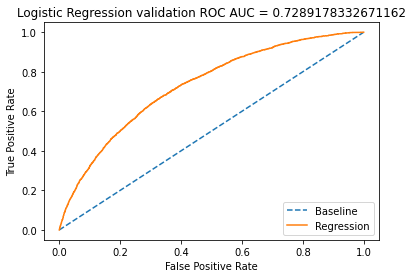

F1 score:  0.3422840504691039


In [43]:
model_resamp2, y_pre_probs_resamp2, y_pre_resamp2 = predict_baseline(X_pretrain_resamp2, X_valid, y_pretrain_resamp2, y_valid)
roc_auc_curve(y_valid, y_pre_probs_resamp2)
print('F1 score: ', f1_score(y_valid, y_pre_resamp2))

Resampling procedures do not improve ROC AUC metric, but have a good impact on F1-score. 

# Tuning hyperparameters
GridSearchCV() uses cross-validation to evaluate model, so it's ok to use all given train data (without one more split on "pretrain" and "valid"). I will use the 1st resampling strategy because it performed slightly better in terms of f1-score.

In [44]:
X_train, y_train, X_test = prepare_data(data, target, num_col, cat_col, bin_col)
X_train_resamp1, y_train_resamp1 = resampling_strategy1(X_train, y_train)

Text(0.5, 0.98, 'Histogram for default in train datasets')

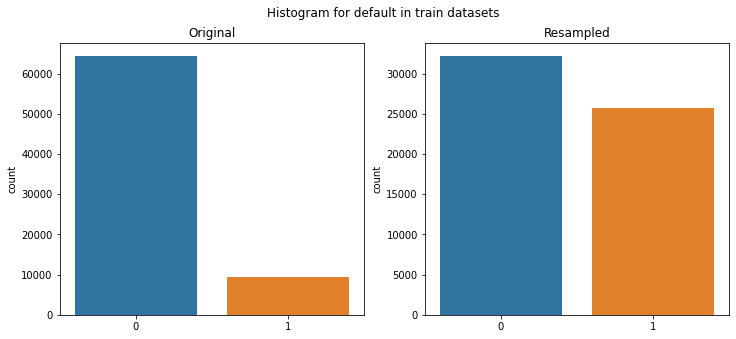

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.countplot(y_train, ax=axes[0])
axes[0].set_title('Original')
sns.countplot(y_train_resamp1, ax=axes[1])
axes[1].set_title('Resampled')
plt.suptitle('Histogram for default in train datasets')

In [46]:
logreg = sk.linear_model.LogisticRegression(random_state=33)
param_grid = {'C': [0.5, 1, 10, 100, 200, 400, 500, 700, 1000],
              'tol': [1e-2, 1e-3, 1e-4],
              'class_weight': [None, 'balanced', {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

research_original_data = sk.model_selection.GridSearchCV(estimator=logreg,
                                               param_grid=param_grid,
                                               scoring='roc_auc',
                                               n_jobs=-1,
                                               verbose=5).fit(X_train, y_train)

research_resampled_data = sk.model_selection.GridSearchCV(estimator=logreg,
                                               param_grid=param_grid,
                                               scoring='roc_auc',
                                               n_jobs=-1,
                                               verbose=5).fit(X_train_resamp1, y_train_resamp1)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 92.9min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 101.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 112.0min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 114.3min finished


Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 41.8min finished


In [47]:
research_original_data.cv_results_

{'mean_fit_time': array([1.88621778e+01, 2.33565867e+01, 2.37405638e+01, 5.96078663e+00,
        4.02719307e+00, 3.00027390e+00, 1.92081041e+00, 2.90145998e+00,
        3.31872315e+00, 1.56670666e+00, 6.14397545e+00, 6.17396259e+00,
        1.38469014e+00, 7.43599558e+00, 1.07402499e+01, 9.02358146e+00,
        2.42731115e+01, 2.68248309e+01, 5.73698416e+00, 4.48291540e+00,
        3.43114400e+00, 2.28587055e+00, 3.03134642e+00, 3.54766626e+00,
        2.65380301e+00, 6.11692019e+00, 6.25328474e+00, 1.91488194e+00,
        8.17038903e+00, 1.12024238e+01, 4.39202313e+00, 8.87475681e+00,
        1.48515391e+01, 5.34022055e+00, 4.71419177e+00, 3.14845181e+00,
        2.20270648e+00, 2.57837529e+00, 2.99332657e+00, 1.61628342e+00,
        6.17547092e+00, 6.44755931e+00, 1.54800630e+00, 8.69284563e+00,
        1.14223351e+01, 5.15104947e+00, 1.05151742e+01, 1.71398093e+01,
        5.82030377e+00, 4.11326289e+00, 3.04227090e+00, 1.63718042e+00,
        2.36484733e+00, 2.54450984e+00, 1.49118

In [48]:
print('Original train dataset')
print('Best model:{}, ROC AUC score: {}'.format(research_original_data.best_estimator_,
                                                research_original_data.best_score_))

Original train dataset
Best model:LogisticRegression(C=10, class_weight={0: 0.2, 1: 0.8}, random_state=33,
                   solver='newton-cg', tol=0.01), ROC AUC score: 0.7303538920306467


In [49]:
research_resampled_data.cv_results_

{'mean_fit_time': array([16.57368002, 18.88231444, 20.82771921,  4.82440076,  2.91306648,
         2.34508533,  0.80241728,  2.02771134,  2.36547904,  1.31991601,
         4.83332348,  5.00953407,  1.45816083,  6.15672526,  8.79296961,
         5.10169911, 13.74567275, 17.7939095 ,  4.26225438,  3.55854974,
         2.89877954,  0.83757763,  2.08886828,  2.40073838,  1.35255189,
         4.97379436,  5.10048795,  1.53953881,  6.30447497,  8.57418518,
         3.73384266,  7.03613672, 12.94095368,  4.32163939,  3.36255579,
         2.41522441,  0.69200964,  1.2802742 ,  1.60857334,  1.37067065,
         5.06687284,  5.18649383,  1.85265617,  6.38983989,  8.3783186 ,
         4.10360909,  8.66541405, 14.80492048,  4.29365897,  3.19420829,
         2.58991432,  0.6866159 ,  1.32968278,  1.67825613,  1.32419   ,
         5.10815134,  5.20232835,  1.72253399,  6.44952178,  8.56521139,
         5.98903604, 16.48280468, 20.21468372,  4.60478029,  3.56984339,
         2.70221601,  0.99644518, 

In [50]:
print('Resampled train dataset')
print('Best model:{}, ROC AUC score: {}'.format(research_resampled_data.best_estimator_,
                                                research_resampled_data.best_score_))

Resampled train dataset
Best model:LogisticRegression(C=200, random_state=33, solver='liblinear', tol=0.001), ROC AUC score: 0.7310839246531377


The best ROC AUC was achieved on resampled training dataset.

In [51]:
best_model = sk.linear_model.LogisticRegression(C=700, random_state=33, solver='liblinear', tol=0.001)
best_model_valid = best_model.fit(X_pretrain_resamp1, y_pretrain_resamp1)
y_pre_proba = best_model_valid.predict_proba(X_valid)[:, 1]
y_pre_pred = best_model_valid.predict(X_valid)
print('F1 score: ', f1_score(y_valid, y_pre_pred))

F1 score:  0.3460467109492179


And F1-score was also improved!

Let's consider how probability threshold (by default 0.5 is used to decide whether the class is 1 or not) affects on F1-score.

In [52]:
def predict_class(y_proba, proba_threshold):
    return (y_proba > proba_threshold).astype(int)

In [53]:
for threshold in [0.4, 0.5, 0.51, 0.52, 0.53, 0.55, 0.56, 0.57, 0.58, 0.6, 0.7, 0.8]:
    y_pre_pred = predict_class(y_pre_proba, threshold)
    print('Probability thershold:{}, F1 score: {}'.format(threshold, f1_score(y_valid, y_pre_pred)))

Probability thershold:0.4, F1 score: 0.32084816591858845
Probability thershold:0.5, F1 score: 0.3460467109492179
Probability thershold:0.51, F1 score: 0.34777765400467864
Probability thershold:0.52, F1 score: 0.3503448275862069
Probability thershold:0.53, F1 score: 0.34947067919590813
Probability thershold:0.55, F1 score: 0.3490155970340067
Probability thershold:0.56, F1 score: 0.34786053882725837
Probability thershold:0.57, F1 score: 0.34478021978021983
Probability thershold:0.58, F1 score: 0.3426124197002141
Probability thershold:0.6, F1 score: 0.3380799265043638
Probability thershold:0.7, F1 score: 0.2667267402568146
Probability thershold:0.8, F1 score: 0.1162136832239925


Defaut 0.5 is the best choice here and refinement to 0.52-0.53 improves the metric slightly.

# Test & Result
Submit probability predictions on test data, link on Kaggle competition is [here](https://www.kaggle.com/c/sf-dst-scoring).

In [54]:
# final training for submitting
X_train, y_train, X_test = prepare_data(data, target, num_col, cat_col, bin_col)
X_train_resamp1, y_train_resamp1 = resampling_strategy1(X_train, y_train)

best_model_test = best_model.fit(X_train, y_train)
y_pred_probs = best_model_test.predict_proba(X_test)

In [55]:
my_submission = pd.DataFrame({'client_id': data.query('sample==1')['client_id'], 
                              'default': y_pred_probs[:, 1]})
my_submission.to_csv('submission.csv', index=False)

In [56]:
my_submission

,client_id,default
0,74835,0.033806
1,17527,0.167685
2,75683,0.070943
3,26883,0.086147
4,28862,0.038806
...,...,...
36344,83775,0.343290
36345,106254,0.011671
36346,81852,0.359965
36347,1971,0.165861


ROC AUC score: 0.73358

Link on leaderboard is [here](https://www.kaggle.com/c/sf-dst-scoring/leaderboard).